# Linear Regression via Least Squares

## Supervised learning

Suppose that you observe $n$, $d$-dimensional, *inputs*:

$$
\mathbf{x}_{1:n} = \{\mathbf{x}_1,\dots,\mathbf{x}_n\},
$$

and *outputs*:

$$
\mathbf{y}_{1:n} = \{y_1,\dots,y_n\}.
$$

The supervised learning problem consists of using the data $\mathbf{x}_{1:n}$ and $\mathbf{y}_{1:n}$ to find
the map that connects the inputs to the outputs.

We call the inputs $\mathbf{x}$ *features*.

The outputs $\mathbf{y}$ are also called *targets*.

### The regression problem

When the outputs are continuous variables, e.g., dollars, weight, and mass, we say we have a *regression* problem.
You may have heard of *linear regression*.
That's when the map that connects the inputs to the outputs is a linear function.
There is also the *generalized linear regression* problem, where the map is a nonlinear function but linear in the parameters.
For example, the map could be a polynomial function of the inputs.
You can also do *nonlinear regression*, where the map is a nonlinear function, and the map is nonlinear in the parameters.
Neural networks are an example of nonlinear regression.

### The classification problem

When the outputs are discrete labels, e.g., 0 or 1, "cat" or "dog," we say we have a *classification* problem.
*Logistic regression* is an example of a classification problem.
You can also solve the classification problem with neural networks.

### How do we train a supervised learning model?

There are two basic ways to train a supervised learning model:

1. Optimization. We find the parameters by maximizing the likelihood of the data. Equivalently, we minimize the negative log-likelihood of the data (the *loss*).

2. Probabilistic inference. We apply Bayes' rule to find the posterior distribution of the parameters given the data. We then use the posterior distribution to make predictions. We can characterize the posterior distribution analytically, sample from it, or approximate it with a simpler distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Linear regression with a single variable

We will now look at a simple linear regression example with a single variable.

## An example where things work as expected

Let's create a synthetic dataset to introduce the basic concepts.
It must be synthetic because we want to know the ground truth.
Let's start with pairs of $x$ and $y$, which have a linear relationship. We contaminate $y$ with Gaussian noise.
In particular, we generate the data from:

$$
y_i = -0.5 + 2 x_i + 0.1\epsilon_i,
$$

where $\epsilon_i \sim N(0,1)$ and where we sample $x_i \sim U([0,1])$.
Here is how to generate this synthetic dataset and what it looks like:

In [2]:
np.random.seed(12345)

num_obs = 10
x = np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
sigma_true = 0.1
y = (
    w0_true
    + w1_true * x
    + sigma_true * np.random.randn(num_obs)
)

Let's plot the data:

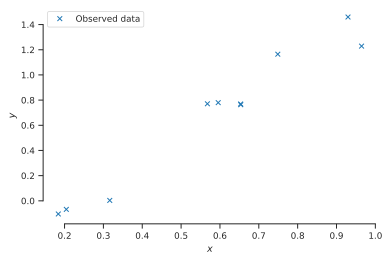

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=True)
sns.despine(trim=True);

We will now use least squares to fit the data to this linear model:

$$
y = w_0 + w_1 x.
$$

Least squares minimize the square loss:

$$
L(\mathbf{w}) = \sum_{i=1}^n(y_i - w_0 - w_1 x_i)^2 = \parallel \mathbf{y} - \mathbf{X}\mathbf{w}\parallel^2,
$$

where $\mathbf{y} = (y_1,\dots,y_n)$ is the vector of observations, $\mathbf{w} = (w_0, w_1)$ is the weight vector, and the $n\times 2$ *design matrix* $\mathbf{X}$ is:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n
\end{bmatrix}.
$$

We need to make the design matrix $\mathbf{X}$:

In [4]:
# Put together a column of ones next to the observed x's
X = np.hstack(
    [np.ones((num_obs, 1)), x.reshape((num_obs, 1))]
)
X

array([[1.        , 0.92961609],
       [1.        , 0.31637555],
       [1.        , 0.18391881],
       [1.        , 0.20456028],
       [1.        , 0.56772503],
       [1.        , 0.5955447 ],
       [1.        , 0.96451452],
       [1.        , 0.6531771 ],
       [1.        , 0.74890664],
       [1.        , 0.65356987]])

Once we have this, we can use [numpy.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html?highlight=lstsq#numpy.linalg.lstsq) to solve the least squares problem. 
This function solves the linear system we derived in the previous section, i.e.,

$$
\mathbf{X}^T\mathbf{X}\mathbf{w} = \mathbf{X}^T\mathbf{y}.
$$

It works as follows:

In [5]:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f'w_0 = {w[0]:1.2f}')
print(f'w_1 = {w[1]:1.2f}')

w_0 = -0.48
w_1 = 1.99


So, the values we found for $w_0$ and $w_1$ are close to the correct values.
The agreement is not perfect.
There is noise in the data, and we have only used ten observations.
The more noise there is, the more observations it would take to identify the regression coefficients correctly.

Let's now plot the regression function against the data:

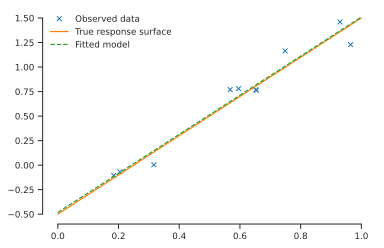

In [6]:
# Make predictions
# Some points on which to evaluate the regression function
xx = np.linspace(0, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx
# The model we just fitted
yy = w[0] + w[1] * xx

# Plot them
fig, ax = plt.subplots()
# plot the data again
ax.plot(x, y, 'x', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
# overlay our prediction
ax.plot(xx, yy, '--', label='Fitted model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Try increasing ``num_obs`` to 100. Does the fit improve? Conclusion: When training with least squares, more data is better.
+ Try decreasing ``num_obs`` to 2. What is happening here? This is an example of fitting the noise.

## An example where things do not work as expected: underfitting

Let's try to fit a linear regression model to data generated from:

$$
y_i = -0.5 + 2x_i + 2x_i^2 + \epsilon_i,
$$

where $\epsilon_i \sim N(0, 1)$ and where we sample $x_i \sim U([-1,1])$:

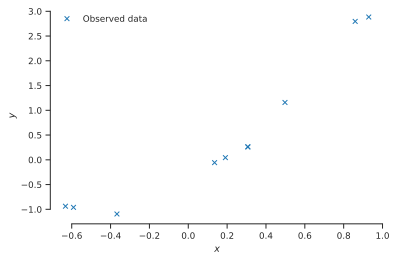

In [7]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true
    + w1_true * x
    + w2_true * x ** 2
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

We will still fit a linear model to this dataset. We know it will not work well, but let's try it anyway.
First, create the design matrix just like before:

In [8]:
X = np.hstack(
    [np.ones((num_obs, 1)), x.reshape((num_obs, 1))]
)

w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

print(f'w_0 = {w[0]:1.2f}')
print(f'w_1 = {w[1]:1.2f}')

w_0 = 0.03
w_1 = 2.46


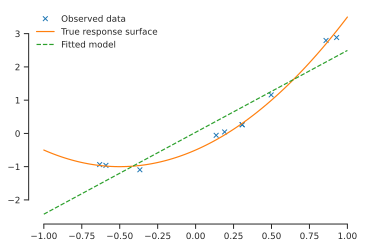

In [9]:
# Make predictions
xx = np.linspace(-1, 1, 100)
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
yy = w[0] + w[1] * xx

# Plot them
fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.plot(xx, yy, '--', label='Fitted model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Experiment with very small ``num_obs``. If you did not know the true response surface, can you say whether or not the fit is good?

+ Experiment with a big ``num_obs``. Does the fit improve? This is an example of *underfitting*. Your model does not have enough expressivity to capture the data.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Polynomial Regression

We take up where we left off in the previous section.
Recall that we tried to fit a linear regression model to data generated from:

$$
y_i = -0.5 + 2x_i + 2x_i^2 + \epsilon_i,
$$

where $\epsilon_i \sim N(0, 1)$ and where we sample $x_i \sim U([-1,1])$:

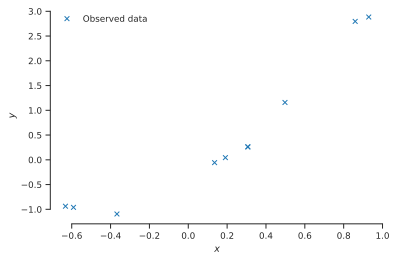

In [11]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true 
    + w1_true * x 
    + w2_true * x ** 2 
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

We already saw that the linear model does not work here.
We need to try to fit a quadratic model:

$$
y = w_0 + w_1 x + w_2 x^2.
$$

How can we do this? Of course, by minimizing the square loss:

$$
L(w_0, w_1, w_2) = \sum_{i=1}^n(y_i - w_0 - w_1 x_i - w_2 x_i^2)^2.
$$

Fortunately, we do not have to do things from scratch.
The notation we developed previously comes to our rescue.
Recall, that $\mathbf{y} = (y_1,\dots,y_n)$ is the vector of observations.
Use

$$
\mathbf{w} = (w_0, w_1, w_2),
$$ 

to denote the weight vector.
What about the design matrix?
Before, it was an $N\times 2$ matrix, with the first column being one and the second being the vector of observed inputs.
Well, now it is the $N\times 3$ matrix.
The first two columns are exactly like before, but now the third column is the observed inputs squared.
So, it is:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 & x_1^2\\
1 & x_2 & x_2^2\\
\vdots & \vdots \\
1 & x_n & x_n^2
\end{bmatrix}.
$$

As before, if you multiply the design matrix $\mathbf{X}$ with the weight vector $\mathbf{w}$, you get the predictions of our model.
We can write the square loss:

$$
L(w_0, w_1, w_2) = L(\mathbf{w}) = \parallel \mathbf{y} - \mathbf{X}\mathbf{w}\parallel^2.
$$

Well, this is mathematically the same equation as before.
The only difference is that we have a 3-dimensional weight vector (instead of a 2-dimensional) and that the design matrix is $n\times 3$ instead of $n\times 2$.
If you take the gradient of this with respect to $\mathbf{w}$ and set it equal to zero, you will get that you need to solve the same linear system of equations as before (but now it is three equations for three unknowns instead of two equations for two unknowns).

Let's solve it numerically.
First, the design matrix:

In [12]:
X = np.hstack(
    [
        np.ones((num_obs, 1)),
        x.reshape((num_obs, 1)),
        x.reshape((num_obs, 1)) ** 2
    ]
)
X

array([[ 1.        ,  0.85923219,  0.73827995],
       [ 1.        , -0.36724889,  0.13487175],
       [ 1.        , -0.63216238,  0.39962927],
       [ 1.        , -0.59087944,  0.34913852],
       [ 1.        ,  0.13545006,  0.01834672],
       [ 1.        ,  0.19108941,  0.03651516],
       [ 1.        ,  0.92902904,  0.86309496],
       [ 1.        ,  0.30635419,  0.09385289],
       [ 1.        ,  0.49781328,  0.24781806],
       [ 1.        ,  0.30713974,  0.09433482]])

and then:

In [13]:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

print(f"w = {w}")

w = [-0.4480109   2.03041492  1.8526404 ]


Let's visualize the model predictions:

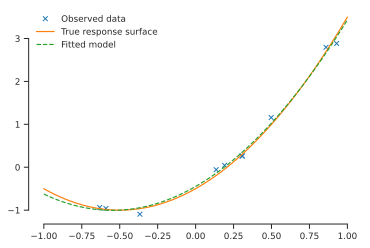

In [14]:
xx = np.linspace(-1, 1, 100)
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
yy = w[0] + w[1] * xx + w[2] * xx ** 2

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.plot(xx, yy, '--', label='Fitted model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Repeat with very small ``num_obs`` and very large ``num_obs`` and observe the behavior of the fit.

## Regression with high-degree polynomials and overfitting

What would have happened if we tried to use a higher-degree polynomial?
To achieve this, we need to be able to evaluate a design matrix of the form:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 & x_1^2\dots & x_1^\rho\\
1 & x_2 & x_2^2\dots & x_2^\rho\\
\vdots & \vdots\dots & \vdots\\
1 & x_n & x_n^2 \dots & x_n^\rho
\end{bmatrix},
$$

where $\rho$ is the degree of the polynomial.
The linear system we need to solve is the same as before.
The weight vector is $\rho + 1$ dimensional and the design matrix $n\times (\rho + 1)$.

Let's write some code to find the design matrix:

In [15]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

Let's try fitting a degree 3 polynomial and see what we get:

In [16]:
# The polynomial degree
degree = 3

# The design matrix is:
X = get_polynomial_design_matrix(x[:, None], degree)

# And we fit just like previously:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f"w = {w}")

w = [-0.54336704  2.38275708  2.29024175 -0.82720627]


Let's visualize the fit.
Notice that for making predictions, I am evaluating the design matrix on the points I want to make predictions at.

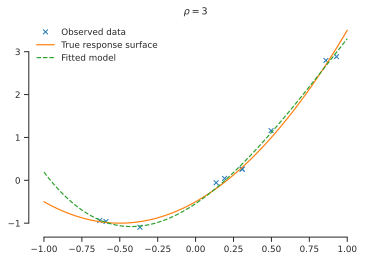

In [17]:
# Make predictions like this:
xx = np.linspace(-1, 1, 100)
XX = get_polynomial_design_matrix(xx[:, None], degree)
yy = XX @ w

# The true response
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

# Plot everything
fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.plot(xx, yy, '--', label='Fitted model')
ax.set_title(f'$\\rho = {degree}$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Start increasing the polynomial degree from 3 to 4 to a number where things get bad. You will soon start *overfitting*.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Measures of Predictive Accuracy


## Training and test datasets

You cannot test how good your model is using the training dataset.
Whatever the metric you use, your model's performance on the training dataset will always be quite good.
The model is tuned to do well on the training data.
The real question is how well your model does on a dataset it has never seen.
This brings us to the concept of a *test dataset*.
How can you make a test dataset?
Well, take whatever data you have and split them into training and test datasets.
For example, you can randomly select 70% of your data and put it in your training set and 30% of the data and put it in your test set.

Let's do this for the motorcycle dataset:

In [19]:
data = np.loadtxt('motor.dat')

x = data[:, 0]
y = data[:, 1]

We are going to use the functionality of the Python library [scikitlearn](https://scikit-learn.org/stable/) to split our dataset into training and testing.

In [20]:
np.random.seed(12345)

from sklearn.model_selection import train_test_split

# Here is how you use it
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Let's plot the training and the test datasets in different colors:

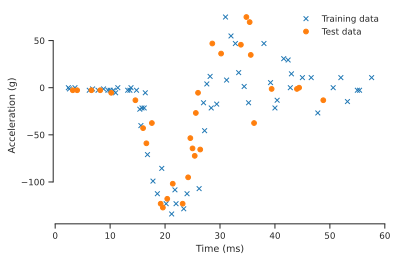

In [21]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Fit the model on the training set

Let's repeat here the code that calculates the design matrix for polynomial, Fourier, and radial basis functions:

In [22]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

Let's fit a polynomial model like before:

In [23]:
degree = 3
Phi_poly_train = get_polynomial_design_matrix(
    x_train[:, None],
    degree
)
w_poly, _, _, _ = np.linalg.lstsq(
    Phi_poly_train,
    y_train,
    rcond=None
)

Let's compare to the data:

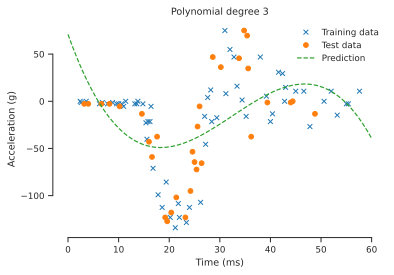

In [24]:
xx = np.linspace(0, 60, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = Phi_poly_xx @ w_poly

fig, ax = plt.subplots()
ax.set_title(f'Polynomial degree {degree}')
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Test the model with the test set: The predictions-vs-observations plot

As you can imagine, you can only do this if the input has less than two dimensions.
In higher dimensions, we typically do the predictions-vs-observations plot for the test data.
We also call it the parity plot.
Here is how it looks:

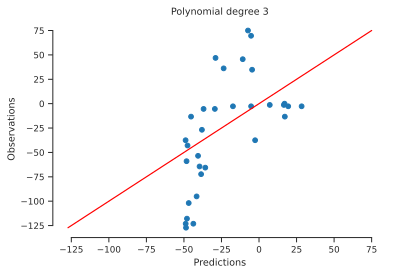

In [25]:
Phi_poly_test = get_polynomial_design_matrix(
    x_test[:, None],
    degree
)
y_test_predict = Phi_poly_test @ w_poly

fig, ax = plt.subplots()
ax.set_title(f'Polynomial degree {degree}')
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

Notice that I have included a red line that goes through the origin at a 45-degree angle with the x-axis in this plot.
This red line marks the perfect fit, i.e., a perfect agreement between the predictions and the observations.
In other words, the closer the blue dots get to the red line, the better the model.

## The mean squared error

The predictions-vs-observations plot is excellent.
But sometimes, you want to characterize your model using a number.
The mean squared error (MSE) is a scalar measure of the goodness of fit.
The MSE is the *mean* of the *sum* of the *square* of the *prediction error* over your test data.
If we assume that you have $n_t$ test data points with inputs $x_{t,i}$ and outputs $y_{t,i}$, the MSE of your model is:

$$
\text{MSE} = \frac{\sum_{i=1}^{n_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{n_t}.
$$

In the polynomial model we fitted above, it is:

In [26]:
MSE_poly = np.mean((y_test_predict - y_test) ** 2)
print(f'MSE_poly = {MSE_poly:1.2f}')

MSE_poly = 2047.76


Now, it is evident that a smaller MSE means a better model.
However, it is hard to understand the absolute meaning of the MSE.
So, sometimes, we look at the relative MSE or (RMSE).
RMSE is the MSE of your model divided by the MSE of the simplest possible model you could make.
Okay. What is the simplest viable model you could make?
It is a constant model.
A model that predicts the same value for the output $y$ no matter what the input $x$ is.
So, mathematically, the model is:

$$
y_{\text{simplest}} = c,
$$

for some constant $c$. What is the best such constant?
You can fit it by minimizing the sum of square errors for this simple model.
If you do it, you will get, very intuitively, that the constant should be the empirical average of your training data, i.e.,

$$
y_{\text{simplest}} = \hat{\mu} = \frac{1}{n}\sum_{i=1}^ny_i.
$$

So, the MSE of this simple model is just:

$$
\text{MSE}_{\text{simplest}} = \frac{\sum_{i=1}^{n_t}\left(y_{t,i} - \hat{\mu}\right)^2}{n_t}.
$$

And we define RMSE to be:

$$
\text{RMSE} = \frac{\text{MSE}}{\text{MSE}_{\text{simplest}}} = \frac{\sum_{i=1}^{n_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{n_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

Now, RMSE has an intuitive meaning.
If it is smaller than one, then this means that your model is doing something better than the simplest possible model.
And the smaller it is, the better you do compared to the simplest model.
If the RMSE exceeds one, your model could be better.

```{note}
Sometimes, the acronym RMSE is used for the root mean square error, which is just the square root of the MSE.
Make sure you know which one you are using.
```

Let's find the RMSE for our case:

In [27]:
mu = y_train.mean()
MSE_simplest = np.mean((y_test - mu) ** 2)
print(f'MSE_simplest = {MSE_simplest:1.2f}')
RMSE_poly = MSE_poly / MSE_simplest
print(f'RMSE_poly = {RMSE_poly:1.2f}')

MSE_simplest = 3150.87
RMSE_poly = 0.65


## Coefficient of determination $R^2$

The coefficient of determination is defined by:

$$
R^2 = 1 - \text{RMSE} = 1 - \frac{\sum_{i=1}^{n_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{n_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

This measure tells you how much of the percentage of the variance of the test data is explained by your model.
So, you want to get as close to one as possible here.

Let's see what we get in our case:

In [28]:
R2_poly = 1 - RMSE_poly
print('R2 = {0:1.2f}'.format(R2_poly))

R2 = 0.35


So, in this example, our model explains about 23% of the variance of the test data.
What is the rest?
Well, the rest is explained by the measurement noise variance.

### Questions

+ Experiment with polynomials of degrees 4, 5, 10, and 20.
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?
+ Use the code blocks below to repeat this analysis for the Fourier and radial basis functions. Which choice of the three basis functions is better? Why?

## Example: Repeat the fitting using Fourier features

Below, I train a model on the same dataset using Fourier features instead of polynomials.
Let's see what we get.

In [29]:
fourier_terms = 10
fourier_L = 60.0
Phi_fourier_train = get_fourier_design_matrix(
    x_train[:, None],
    fourier_L,
    fourier_terms
)
w_fourier, _, _, _ = np.linalg.lstsq(
    Phi_fourier_train,
    y_train,
    rcond=None
)

The predictions plot:

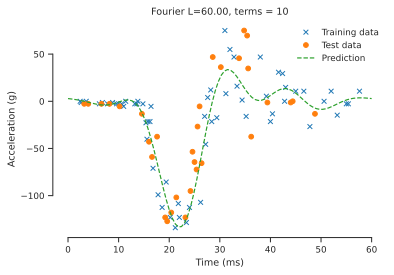

In [30]:
xx = np.linspace(0, 60, 100)
Phi_fourier_xx = get_fourier_design_matrix(
    xx[:, None],
    fourier_L,
    fourier_terms
)
yy_predict = Phi_fourier_xx @ w_fourier

fig, ax = plt.subplots()
ax.set_title(f'Fourier L={fourier_L:1.2f}, terms = {fourier_terms}')
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

And here is the predictions-vs-observations plot:

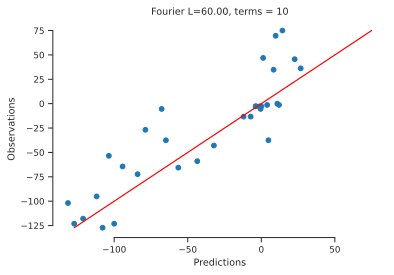

In [31]:
Phi_fourier_test = get_fourier_design_matrix(
    x_test[:, None],
    fourier_L,
    fourier_terms
)
y_test_predict = Phi_fourier_test @ w_fourier

fig, ax = plt.subplots()
ax.set_title(
    f'Fourier L={fourier_L:1.2f}, terms = {fourier_terms}'
)
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

And the error metrics we developed:

In [32]:
MSE_fourier = np.mean((y_test_predict - y_test) ** 2)
RMSE_fourier = MSE_fourier / MSE_simplest
R2_fourier = 1 - RMSE_fourier

print(f'MSE_fourier = {MSE_fourier:1.2f}')
print(f'RMSE_fourier = {RMSE_fourier:1.2f}')
print(f'R2 = {R2_fourier:1.2f}')

MSE_fourier = 820.57
RMSE_fourier = 0.26
R2 = 0.74


You see that this does much, much better than the polynomial model by all measures.
In particular, R2 tells us that our model explains 81% of the variance of the test data.